In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install Sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 31.1 MB/s 


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.datasets import fetch_20newsgroups
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import AlbertTokenizer
from transformers import AlbertForSequenceClassification
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.ticker as ticker
import time
%matplotlib inline
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [5]:
X_train, y_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), return_X_y=True)
X_train = X_train[:5500]
y_train = y_train[:5500]
X_test, y_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), return_X_y=True)

In [ ]:
model = AlbertForSequenceClassification.from_pretrained(
    "albert-base-v2", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 20, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Downloading:   0%|          | 0.00/684 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/45.2M [00:00<?, ?B/s]

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.dense.weight', 'predictions.decoder.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768,

In [6]:
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

Downloading:   0%|          | 0.00/742k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/684 [00:00<?, ?B/s]

In [7]:
def tokenizing(X, y, max_length=64):
    max_len = 0

    # For every sentence...
    for sent in X:

        # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
        input_ids = tokenizer.encode(sent, add_special_tokens=True)

        # Update the maximum sentence length.
        max_len = max(max_len, len(input_ids))

    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in X:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_length,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                            #truncation=True
                    )
        
        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])
        
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(y)
    return input_ids, attention_masks, labels

In [8]:
# Combine the training inputs into a TensorDataset.
input_ids, attention_masks, labels = tokenizing(X_train, y_train)
dataset = TensorDataset(input_ids, attention_masks, labels)
input_ids, attention_masks, labels = tokenizing(X_test, y_test)
test_dataset = TensorDataset(input_ids, attention_masks, labels)

Token indices sequence length is longer than the specified maximum sequence length for this model (539 > 512). Running this sequence through the model will result in indexing errors
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [9]:
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

4,950 training samples
  550 validation samples


In [10]:
epochs = 20

In [11]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [12]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [16]:
import random

def training(train_dataloader, validation_dataloader, optimizer, scheduler, epochs=20):
    device='cuda'

    # This training code is based on the `run_glue.py` script here:
    # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

    # Set the seed value all over the place to make this reproducible.
    seed_val = 42

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # We'll store a number of quantities such as training and validation loss, 
    # validation accuracy, and timings.
    training_stats = []

    # Measure the total training time for the whole run.
    total_t0 = time.time()

    # For each epoch...
    for epoch_i in range(0, epochs):
        
        # ========================================
        #               Training
        # ========================================
        
        # Perform one full pass over the training set.

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0
        total_train_accuracy = 0

        # Put the model into training mode. Don't be mislead--the call to 
        # `train` just changes the *mode*, it doesn't *perform* the training.
        # `dropout` and `batchnorm` layers behave differently during training
        # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)
                
                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the 
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because 
            # accumulating the gradients is "convenient while training RNNs". 
            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            model.zero_grad()        

            # Perform a forward pass (evaluate the model on this training batch).
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # It returns different numbers of parameters depending on what arguments
            # arge given and what flags are set. For our useage here, it returns
            # the loss (because we provided labels) and the "logits"--the model
            # outputs prior to activation.
            an = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask, 
                                labels=b_labels)           
            loss, logits = an['loss'], an['logits']


            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value 
            # from the tensor.
            total_train_loss += loss.item()
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            total_train_accuracy += flat_accuracy(logits, label_ids)

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            
        avg_train_accuracy = total_train_accuracy / len(train_dataloader)
        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Average training accuracy: {0:.2f}".format(avg_train_accuracy))
        print("  Training epcoh took: {:}".format(training_time))
            
        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Tracking variables 
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:
            
            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using 
            # the `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():        

                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # Get the "logits" output by the model. The "logits" are the output
                # values prior to applying an activation function like the softmax.
                an = model(b_input_ids, 
                                      token_type_ids=None, 
                                      attention_mask=b_input_mask,
                                      labels=b_labels)            
                loss, logits = an['loss'], an['logits']

                
            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += flat_accuracy(logits, label_ids)
            

        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        
        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)
        
        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Training Accur.': avg_train_accuracy,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
    return training_stats

In [ ]:
batch_sizes = [16, 32, 64]
batch_dict = dict()
for b in batch_sizes:
    train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = b # Trains with this batch size.
        )
    # For validation the order doesn't matter, so we'll just read them sequentially.
    validation_dataloader = DataLoader(
                val_dataset, # The validation samples.
                sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                batch_size = b # Evaluate with this batch size.
            )
    model = AlbertForSequenceClassification.from_pretrained(
        'albert-base-v2', # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 20, # The number of output labels--2 for binary classification.
                        # You can increase this for multi-class tasks.   
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
    )

    # Tell pytorch to run this model on the GPU.
    model.cuda()
    optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    batch_dict[b] = training(train_dataloader, validation_dataloader, optimizer, scheduler)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.dense.weight', 'predictions.decoder.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho


======== Epoch 1 / 20 ========
Training...
  Batch    40  of    310.    Elapsed: 0:00:08.
  Batch    80  of    310.    Elapsed: 0:00:15.
  Batch   120  of    310.    Elapsed: 0:00:23.
  Batch   160  of    310.    Elapsed: 0:00:31.
  Batch   200  of    310.    Elapsed: 0:00:39.
  Batch   240  of    310.    Elapsed: 0:00:47.
  Batch   280  of    310.    Elapsed: 0:00:54.

  Average training loss: 2.24
  Average training accuracy: 0.32
  Training epcoh took: 0:01:00

Running Validation...
  Accuracy: 0.48
  Validation Loss: 1.69
  Validation took: 0:00:02

======== Epoch 2 / 20 ========
Training...
  Batch    40  of    310.    Elapsed: 0:00:08.
  Batch    80  of    310.    Elapsed: 0:00:15.
  Batch   120  of    310.    Elapsed: 0:00:23.
  Batch   160  of    310.    Elapsed: 0:00:31.
  Batch   200  of    310.    Elapsed: 0:00:38.
  Batch   240  of    310.    Elapsed: 0:00:46.
  Batch   280  of    310.    Elapsed: 0:00:54.

  Average training loss: 1.48
  Average training accuracy: 0.55
  

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.dense.weight', 'predictions.decoder.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho


======== Epoch 1 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:14.
  Batch    80  of    155.    Elapsed: 0:00:28.
  Batch   120  of    155.    Elapsed: 0:00:42.

  Average training loss: 2.38
  Average training accuracy: 0.29
  Training epcoh took: 0:00:55

Running Validation...
  Accuracy: 0.49
  Validation Loss: 1.76
  Validation took: 0:00:02

======== Epoch 2 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:14.
  Batch    80  of    155.    Elapsed: 0:00:28.
  Batch   120  of    155.    Elapsed: 0:00:42.

  Average training loss: 1.54
  Average training accuracy: 0.55
  Training epcoh took: 0:00:55

Running Validation...
  Accuracy: 0.55
  Validation Loss: 1.53
  Validation took: 0:00:02

======== Epoch 3 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:14.
  Batch    80  of    155.    Elapsed: 0:00:28.
  Batch   120  of    155.    Elapsed: 0:00:42.

  Average training loss: 1.21
  Average training accuracy: 0.64
  Trai

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.dense.weight', 'predictions.decoder.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho


======== Epoch 1 / 20 ========
Training...
  Batch    40  of     78.    Elapsed: 0:00:28.

  Average training loss: 2.68
  Average training accuracy: 0.20
  Training epcoh took: 0:00:55

Running Validation...
  Accuracy: 0.38
  Validation Loss: 2.12
  Validation took: 0:00:02

======== Epoch 2 / 20 ========
Training...
  Batch    40  of     78.    Elapsed: 0:00:28.

  Average training loss: 1.83
  Average training accuracy: 0.47
  Training epcoh took: 0:00:55

Running Validation...
  Accuracy: 0.50
  Validation Loss: 1.65
  Validation took: 0:00:02

======== Epoch 3 / 20 ========
Training...
  Batch    40  of     78.    Elapsed: 0:00:28.

  Average training loss: 1.44
  Average training accuracy: 0.58
  Training epcoh took: 0:00:55

Running Validation...
  Accuracy: 0.54
  Validation Loss: 1.48
  Validation took: 0:00:02

======== Epoch 4 / 20 ========
Training...
  Batch    40  of     78.    Elapsed: 0:00:28.

  Average training loss: 1.17
  Average training accuracy: 0.67
  Training

In [14]:
def show_table(training_stats):
    # Display floats with two decimal places.
    pd.set_option('precision', 2)

    # Create a DataFrame from our training statistics.
    df_stats = pd.DataFrame(data=training_stats)

    # Use the 'epoch' as the row index.
    df_stats = df_stats.set_index('epoch')

    # A hack to force the column headers to wrap.
    #df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

    # Display the table.
    return df_stats

In [ ]:
show_table(batch_dict[16])

,Training Loss,Training Accur.,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.24,0.32,1.69,0.48,0:01:00,0:00:02
2,1.48,0.55,1.49,0.57,0:00:59,0:00:02
3,1.13,0.66,1.36,0.58,0:01:00,0:00:02
4,0.87,0.73,1.35,0.59,0:01:00,0:00:02
5,0.66,0.81,1.40,0.60,0:01:00,0:00:02
6,0.49,0.86,1.45,0.59,0:01:00,0:00:02
7,0.35,0.91,1.52,0.60,0:01:00,0:00:02
8,0.25,0.93,1.56,0.63,0:01:00,0:00:02
9,0.20,0.95,1.66,0.62,0:01:00,0:00:02


In [ ]:
show_table(batch_dict[32])

,Training Loss,Training Accur.,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.38,0.29,1.76,0.49,0:00:55,0:00:02
2,1.54,0.55,1.53,0.55,0:00:55,0:00:02
3,1.21,0.64,1.43,0.58,0:00:55,0:00:02
4,0.96,0.72,1.33,0.58,0:00:55,0:00:02
5,0.75,0.78,1.39,0.60,0:00:55,0:00:02
6,0.59,0.84,1.33,0.60,0:00:55,0:00:02
7,0.46,0.88,1.40,0.59,0:00:55,0:00:02
8,0.34,0.92,1.41,0.61,0:00:55,0:00:02
9,0.26,0.94,1.50,0.60,0:00:55,0:00:02


In [ ]:
show_table(batch_dict[64])

,Training Loss,Training Accur.,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.68,0.20,2.12,0.38,0:00:55,0:00:02
2,1.83,0.47,1.65,0.50,0:00:55,0:00:02
3,1.44,0.58,1.48,0.54,0:00:55,0:00:02
4,1.17,0.67,1.39,0.57,0:00:54,0:00:02
5,0.98,0.72,1.36,0.58,0:00:55,0:00:02
6,0.83,0.77,1.34,0.60,0:00:55,0:00:02
7,0.70,0.82,1.35,0.60,0:00:55,0:00:02
8,0.59,0.85,1.36,0.60,0:00:55,0:00:02
9,0.50,0.88,1.39,0.60,0:00:55,0:00:02


In [ ]:
loss_train = dict()
loss_test = dict()
acc_train = dict()
acc_test = dict()
for key in batch_dict:
    for list_ in batch_dict[key]:
        if key in loss_train:
            loss_train[key].append(list_['Training Loss'])
            loss_test[key].append(list_['Valid. Loss'])
            acc_test[key].append(list_['Valid. Accur.'])
            acc_train[key].append(list_['Training Accur.'])
        else:
            loss_train[key] = [list_['Training Loss']]
            loss_test[key] = [list_['Valid. Loss']]
            acc_test[key] = [list_['Valid. Accur.']]
            acc_train[key] = [list_['Training Accur.']]

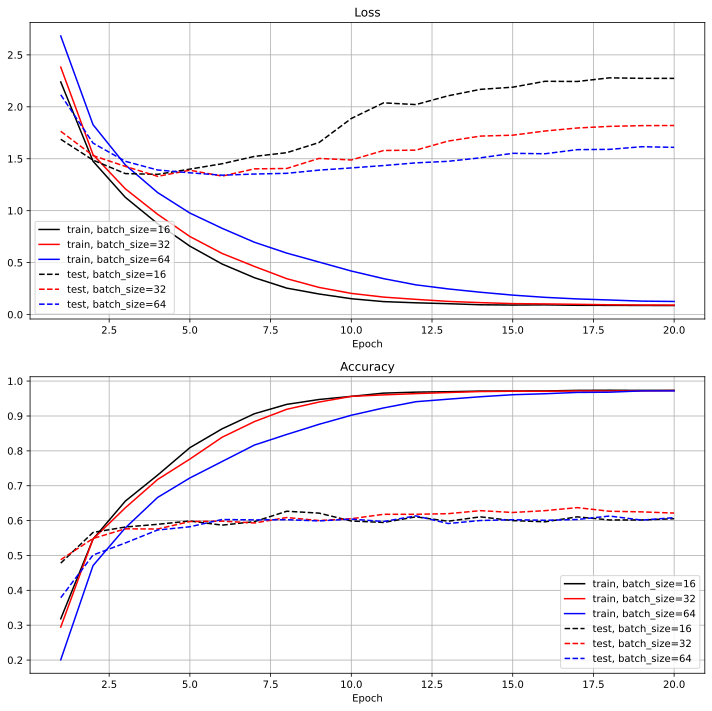

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

axes[0].plot(np.arange(20) + 1, loss_train[16], label='train, batch_size=16', linestyle='-', c='black')
axes[0].plot(np.arange(20) + 1, loss_train[32], label='train, batch_size=32', linestyle='-', c='r')
axes[0].plot(np.arange(20) + 1, loss_train[64], label='train, batch_size=64', linestyle='-', c='b')

axes[0].plot(np.arange(20) + 1, loss_test[16], label='test, batch_size=16', linestyle='--', c='black')
axes[0].plot(np.arange(20) + 1, loss_test[32], label='test, batch_size=32', linestyle='--', c='r')
axes[0].plot(np.arange(20) + 1, loss_test[64], label='test, batch_size=64', linestyle='--', c='b')

axes[1].plot(np.arange(20) + 1, acc_train[16], label='train, batch_size=16', linestyle='-', c='black')
axes[1].plot(np.arange(20) + 1, acc_train[32], label='train, batch_size=32', linestyle='-', c='r')
axes[1].plot(np.arange(20) + 1, acc_train[64], label='train, batch_size=64', linestyle='-', c='b')

axes[1].plot(np.arange(20) + 1, acc_test[16], label='test, batch_size=16', linestyle='--', c='black')
axes[1].plot(np.arange(20) + 1, acc_test[32], label='test, batch_size=32', linestyle='--', c='r')
axes[1].plot(np.arange(20) + 1, acc_test[64], label='test, batch_size=64', linestyle='--', c='b')

axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Epoch')
axes[0].set_title('Loss')

axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Epoch')
axes[1].set_title('Accuracy')

fig.tight_layout()
plt.show()

In [ ]:
lrs = [5e-5, 4e-5, 3e-5, 2e-5]
lrs_dict = dict()
for lr in lrs:
    train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = 32 # Trains with this batch size.
        )

    # For validation the order doesn't matter, so we'll just read them sequentially.
    validation_dataloader = DataLoader(
                val_dataset, # The validation samples.
                sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                batch_size = 32 # Evaluate with this batch size.
            )
    model = AlbertForSequenceClassification.from_pretrained(
        'albert-base-v2', # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 20, # The number of output labels--2 for binary classification.
                        # You can increase this for multi-class tasks.   
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
    )

    # Tell pytorch to run this model on the GPU.
    model.cuda()
    optimizer = AdamW(model.parameters(),
                  lr = lr, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    lrs_dict[lr] = training(train_dataloader, validation_dataloader, optimizer, scheduler)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.dense.weight', 'predictions.decoder.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho


======== Epoch 1 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:14.
  Batch    80  of    155.    Elapsed: 0:00:28.
  Batch   120  of    155.    Elapsed: 0:00:43.

  Average training loss: 2.43
  Average training accuracy: 0.23
  Training epcoh took: 0:00:55

Running Validation...
  Accuracy: 0.36
  Validation Loss: 1.97
  Validation took: 0:00:02

======== Epoch 2 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:14.
  Batch    80  of    155.    Elapsed: 0:00:28.
  Batch   120  of    155.    Elapsed: 0:00:42.

  Average training loss: 1.77
  Average training accuracy: 0.43
  Training epcoh took: 0:00:54

Running Validation...
  Accuracy: 0.47
  Validation Loss: 1.70
  Validation took: 0:00:02

======== Epoch 3 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:14.
  Batch    80  of    155.    Elapsed: 0:00:28.
  Batch   120  of    155.    Elapsed: 0:00:42.

  Average training loss: 1.47
  Average training accuracy: 0.54
  Trai

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.dense.weight', 'predictions.decoder.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho


======== Epoch 1 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:14.
  Batch    80  of    155.    Elapsed: 0:00:28.
  Batch   120  of    155.    Elapsed: 0:00:42.

  Average training loss: 2.36
  Average training accuracy: 0.27
  Training epcoh took: 0:00:55

Running Validation...
  Accuracy: 0.48
  Validation Loss: 1.74
  Validation took: 0:00:02

======== Epoch 2 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:14.
  Batch    80  of    155.    Elapsed: 0:00:28.
  Batch   120  of    155.    Elapsed: 0:00:42.

  Average training loss: 1.50
  Average training accuracy: 0.54
  Training epcoh took: 0:00:55

Running Validation...
  Accuracy: 0.58
  Validation Loss: 1.46
  Validation took: 0:00:02

======== Epoch 3 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:14.
  Batch    80  of    155.    Elapsed: 0:00:28.
  Batch   120  of    155.    Elapsed: 0:00:42.

  Average training loss: 1.14
  Average training accuracy: 0.65
  Trai

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.dense.weight', 'predictions.decoder.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho


======== Epoch 1 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:14.
  Batch    80  of    155.    Elapsed: 0:00:28.
  Batch   120  of    155.    Elapsed: 0:00:42.

  Average training loss: 2.24
  Average training accuracy: 0.33
  Training epcoh took: 0:00:55

Running Validation...
  Accuracy: 0.48
  Validation Loss: 1.68
  Validation took: 0:00:02

======== Epoch 2 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:14.
  Batch    80  of    155.    Elapsed: 0:00:28.
  Batch   120  of    155.    Elapsed: 0:00:42.

  Average training loss: 1.43
  Average training accuracy: 0.56
  Training epcoh took: 0:00:55

Running Validation...
  Accuracy: 0.56
  Validation Loss: 1.44
  Validation took: 0:00:02

======== Epoch 3 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:14.
  Batch    80  of    155.    Elapsed: 0:00:28.
  Batch   120  of    155.    Elapsed: 0:00:42.

  Average training loss: 1.09
  Average training accuracy: 0.67
  Trai

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.dense.weight', 'predictions.decoder.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho


======== Epoch 1 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:14.
  Batch    80  of    155.    Elapsed: 0:00:28.
  Batch   120  of    155.    Elapsed: 0:00:42.

  Average training loss: 2.38
  Average training accuracy: 0.29
  Training epcoh took: 0:00:55

Running Validation...
  Accuracy: 0.49
  Validation Loss: 1.76
  Validation took: 0:00:02

======== Epoch 2 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:14.
  Batch    80  of    155.    Elapsed: 0:00:28.
  Batch   120  of    155.    Elapsed: 0:00:42.

  Average training loss: 1.54
  Average training accuracy: 0.55
  Training epcoh took: 0:00:55

Running Validation...
  Accuracy: 0.55
  Validation Loss: 1.53
  Validation took: 0:00:02

======== Epoch 3 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:14.
  Batch    80  of    155.    Elapsed: 0:00:28.
  Batch   120  of    155.    Elapsed: 0:00:42.

  Average training loss: 1.21
  Average training accuracy: 0.64
  Trai

In [ ]:
show_table(lrs_dict[5e-5])

,Training Loss,Training Accur.,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.43,0.23,1.97,0.36,0:00:55,0:00:02
2,1.77,0.43,1.70,0.47,0:00:54,0:00:02
3,1.47,0.54,1.65,0.50,0:00:55,0:00:02
4,1.20,0.62,1.55,0.52,0:00:55,0:00:02
5,1.01,0.68,1.52,0.56,0:00:55,0:00:02
6,0.80,0.75,1.57,0.55,0:00:55,0:00:02
7,0.64,0.81,1.74,0.54,0:00:55,0:00:02
8,0.50,0.86,1.79,0.58,0:00:55,0:00:02
9,0.39,0.89,1.66,0.60,0:00:55,0:00:02


In [ ]:
show_table(lrs_dict[4e-5])

,Training Loss,Training Accur.,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.36,0.27,1.74,0.48,0:00:55,0:00:02
2,1.50,0.54,1.46,0.58,0:00:55,0:00:02
3,1.14,0.65,1.41,0.59,0:00:55,0:00:02
4,0.88,0.73,1.32,0.61,0:00:55,0:00:02
5,0.66,0.80,1.36,0.61,0:00:55,0:00:02
6,0.47,0.86,1.43,0.60,0:00:55,0:00:02
7,0.35,0.90,1.51,0.60,0:00:55,0:00:02
8,0.26,0.93,1.57,0.64,0:00:55,0:00:02
9,0.19,0.95,1.62,0.61,0:00:55,0:00:02


In [ ]:
show_table(lrs_dict[3e-5])

,Training Loss,Training Accur.,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.24,0.33,1.68,0.48,0:00:55,0:00:02
2,1.43,0.56,1.44,0.56,0:00:55,0:00:02
3,1.09,0.67,1.37,0.59,0:00:55,0:00:02
4,0.83,0.75,1.31,0.62,0:00:55,0:00:02
5,0.63,0.82,1.45,0.58,0:00:55,0:00:02
6,0.49,0.86,1.40,0.61,0:00:55,0:00:02
7,0.36,0.91,1.43,0.61,0:00:55,0:00:02
8,0.26,0.93,1.51,0.61,0:00:55,0:00:02
9,0.20,0.95,1.67,0.59,0:00:55,0:00:02


In [ ]:
show_table(lrs_dict[2e-5])

,Training Loss,Training Accur.,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.38,0.29,1.76,0.49,0:00:55,0:00:02
2,1.54,0.55,1.53,0.55,0:00:55,0:00:02
3,1.21,0.64,1.43,0.58,0:00:55,0:00:02
4,0.96,0.72,1.33,0.58,0:00:55,0:00:02
5,0.75,0.78,1.39,0.60,0:00:55,0:00:02
6,0.59,0.84,1.33,0.60,0:00:55,0:00:02
7,0.46,0.88,1.40,0.59,0:00:55,0:00:02
8,0.34,0.92,1.41,0.61,0:00:55,0:00:02
9,0.26,0.94,1.50,0.60,0:00:55,0:00:02


In [ ]:
loss_train = dict()
loss_test = dict()
acc_train = dict()
acc_test = dict()
for key in lrs_dict:
    for list_ in lrs_dict[key]:
        if key in loss_train:
            loss_train[key].append(list_['Training Loss'])
            loss_test[key].append(list_['Valid. Loss'])
            acc_test[key].append(list_['Valid. Accur.'])
            acc_train[key].append(list_['Training Accur.'])
        else:
            loss_train[key] = [list_['Training Loss']]
            loss_test[key] = [list_['Valid. Loss']]
            acc_test[key] = [list_['Valid. Accur.']]
            acc_train[key] = [list_['Training Accur.']]

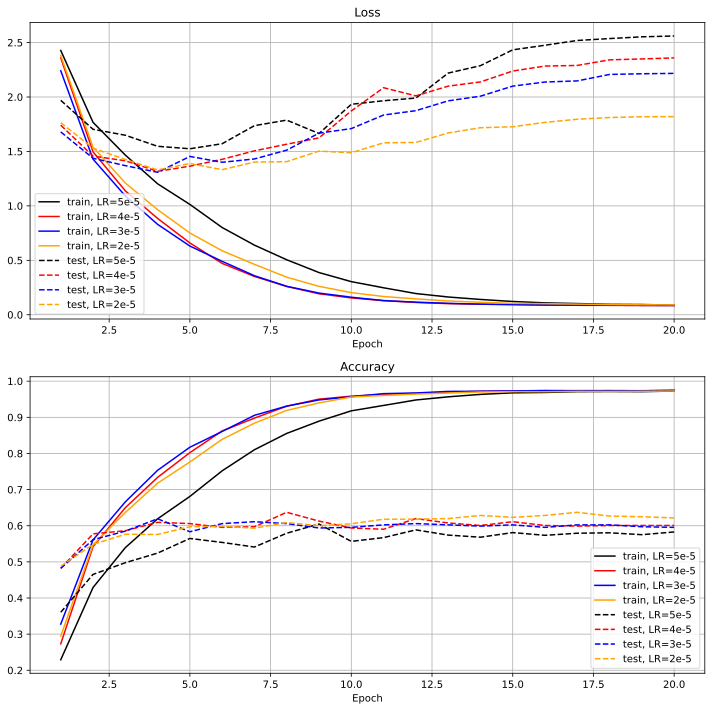

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

axes[0].plot(np.arange(20) + 1, loss_train[5e-5], label='train, LR=5e-5', linestyle='-', c='black')
axes[0].plot(np.arange(20) + 1, loss_train[4e-5], label='train, LR=4e-5', linestyle='-', c='r')
axes[0].plot(np.arange(20) + 1, loss_train[3e-5], label='train, LR=3e-5', linestyle='-', c='b')
axes[0].plot(np.arange(20) + 1, loss_train[2e-5], label='train, LR=2e-5', linestyle='-', c='orange')

axes[0].plot(np.arange(20) + 1, loss_test[5e-5], label='test, LR=5e-5', linestyle='--', c='black')
axes[0].plot(np.arange(20) + 1, loss_test[4e-5], label='test, LR=4e-5', linestyle='--', c='r')
axes[0].plot(np.arange(20) + 1, loss_test[3e-5], label='test, LR=3e-5', linestyle='--', c='b')
axes[0].plot(np.arange(20) + 1, loss_test[2e-5], label='test, LR=2e-5', linestyle='--', c='orange')

axes[1].plot(np.arange(20) + 1, acc_train[5e-5], label='train, LR=5e-5', linestyle='-', c='black')
axes[1].plot(np.arange(20) + 1, acc_train[4e-5], label='train, LR=4e-5', linestyle='-', c='r')
axes[1].plot(np.arange(20) + 1, acc_train[3e-5], label='train, LR=3e-5', linestyle='-', c='b')
axes[1].plot(np.arange(20) + 1, acc_train[2e-5], label='train, LR=2e-5', linestyle='-', c='orange')

axes[1].plot(np.arange(20) + 1, acc_test[5e-5], label='test, LR=5e-5', linestyle='--', c='black')
axes[1].plot(np.arange(20) + 1, acc_test[4e-5], label='test, LR=4e-5', linestyle='--', c='r')
axes[1].plot(np.arange(20) + 1, acc_test[3e-5], label='test, LR=3e-5', linestyle='--', c='b')
axes[1].plot(np.arange(20) + 1, acc_test[2e-5], label='test, LR=2e-5', linestyle='--', c='orange')

axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Epoch')
axes[0].set_title('Loss')

axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Epoch')
axes[1].set_title('Accuracy')

fig.tight_layout()
plt.show()

2e-5, как оказалось, подходит лучше всего.

In [ ]:
max_lens = [25, 50, 70, 100]
ml_dict = dict()
for ml in max_lens:
    input_ids, attention_masks, labels = tokenizing(X_train, y_train, max_length=ml)
    dataset = TensorDataset(input_ids, attention_masks, labels)
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size

    # Divide the dataset by randomly selecting samples.
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = 32 # Trains with this batch size.
        )

    # For validation the order doesn't matter, so we'll just read them sequentially.
    validation_dataloader = DataLoader(
                val_dataset, # The validation samples.
                sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                batch_size = 32 # Evaluate with this batch size.
            )
    model = AlbertForSequenceClassification.from_pretrained(
        'albert-base-v2', # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 20, # The number of output labels--2 for binary classification.
                        # You can increase this for multi-class tasks.   
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
    )

    # Tell pytorch to run this model on the GPU.
    model.cuda()
    optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    ml_dict[ml] = training(train_dataloader, validation_dataloader, optimizer, scheduler)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.dense.weight', 'predictions.decoder.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho


======== Epoch 1 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:06.
  Batch    80  of    155.    Elapsed: 0:00:12.
  Batch   120  of    155.    Elapsed: 0:00:18.

  Average training loss: 2.71
  Average training accuracy: 0.15
  Training epcoh took: 0:00:23

Running Validation...
  Accuracy: 0.23
  Validation Loss: 2.52
  Validation took: 0:00:01

======== Epoch 2 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:06.
  Batch    80  of    155.    Elapsed: 0:00:12.
  Batch   120  of    155.    Elapsed: 0:00:18.

  Average training loss: 2.18
  Average training accuracy: 0.33
  Training epcoh took: 0:00:23

Running Validation...
  Accuracy: 0.35
  Validation Loss: 2.10
  Validation took: 0:00:01

======== Epoch 3 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:06.
  Batch    80  of    155.    Elapsed: 0:00:12.
  Batch   120  of    155.    Elapsed: 0:00:18.

  Average training loss: 1.81
  Average training accuracy: 0.44
  Trai

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.dense.weight', 'predictions.decoder.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho


======== Epoch 1 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:11.
  Batch    80  of    155.    Elapsed: 0:00:23.
  Batch   120  of    155.    Elapsed: 0:00:35.

  Average training loss: 2.66
  Average training accuracy: 0.17
  Training epcoh took: 0:00:45

Running Validation...
  Accuracy: 0.24
  Validation Loss: 2.35
  Validation took: 0:00:02

======== Epoch 2 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:11.
  Batch    80  of    155.    Elapsed: 0:00:23.
  Batch   120  of    155.    Elapsed: 0:00:34.

  Average training loss: 1.95
  Average training accuracy: 0.41
  Training epcoh took: 0:00:44

Running Validation...
  Accuracy: 0.41
  Validation Loss: 1.90
  Validation took: 0:00:02

======== Epoch 3 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:11.
  Batch    80  of    155.    Elapsed: 0:00:23.
  Batch   120  of    155.    Elapsed: 0:00:34.

  Average training loss: 1.58
  Average training accuracy: 0.52
  Trai

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.dense.weight', 'predictions.decoder.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho


======== Epoch 1 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:16.
  Batch    80  of    155.    Elapsed: 0:00:33.
  Batch   120  of    155.    Elapsed: 0:00:49.

  Average training loss: 2.42
  Average training accuracy: 0.27
  Training epcoh took: 0:01:04

Running Validation...
  Accuracy: 0.43
  Validation Loss: 1.94
  Validation took: 0:00:03

======== Epoch 2 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:16.
  Batch    80  of    155.    Elapsed: 0:00:32.
  Batch   120  of    155.    Elapsed: 0:00:49.

  Average training loss: 1.64
  Average training accuracy: 0.50
  Training epcoh took: 0:01:03

Running Validation...
  Accuracy: 0.51
  Validation Loss: 1.59
  Validation took: 0:00:03

======== Epoch 3 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:16.
  Batch    80  of    155.    Elapsed: 0:00:32.
  Batch   120  of    155.    Elapsed: 0:00:49.

  Average training loss: 1.27
  Average training accuracy: 0.61
  Trai

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.dense.weight', 'predictions.decoder.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho


======== Epoch 1 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:23.
  Batch    80  of    155.    Elapsed: 0:00:46.
  Batch   120  of    155.    Elapsed: 0:01:09.

  Average training loss: 2.41
  Average training accuracy: 0.26
  Training epcoh took: 0:01:28

Running Validation...
  Accuracy: 0.40
  Validation Loss: 1.91
  Validation took: 0:00:04

======== Epoch 2 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:23.
  Batch    80  of    155.    Elapsed: 0:00:46.
  Batch   120  of    155.    Elapsed: 0:01:08.

  Average training loss: 1.58
  Average training accuracy: 0.53
  Training epcoh took: 0:01:28

Running Validation...
  Accuracy: 0.54
  Validation Loss: 1.51
  Validation took: 0:00:04

======== Epoch 3 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:23.
  Batch    80  of    155.    Elapsed: 0:00:45.
  Batch   120  of    155.    Elapsed: 0:01:08.

  Average training loss: 1.20
  Average training accuracy: 0.65
  Trai

In [ ]:
training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Training Accur.': avg_train_accuracy,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )

In [ ]:
ml_dict = dict()
ml_dict[25] = []
ml_dict[50] = []
ml_dict[70] = []
ml_dict[100] = []

In [ ]:
ml_dict[25].append(
            {
                'epoch': 1,
                'Training Loss': 2.71,
                'Training Accur.': 0.15,
                'Valid. Loss': 2.52,
                'Valid. Accur.': 0.23,
                'Training Time': '0:00:23',
                'Validation Time': '0:00:01'
            }
        )

ml_dict[25].append(
            {
                'epoch': 2,
                'Training Loss': 2.18,
                'Training Accur.': 0.33,
                'Valid. Loss': 2.10,
                'Valid. Accur.': 0.35,
                'Training Time': '0:00:23',
                'Validation Time': '0:00:01'
            }
        )

ml_dict[25].append(
            {
                'epoch': 3,
                'Training Loss': 1.81,
                'Training Accur.': 0.44,
                'Valid. Loss': 1.94,
                'Valid. Accur.': 0.43,
                'Training Time': '0:00:23',
                'Validation Time': '0:00:01'
            }
        )

ml_dict[25].append(
            {
                'epoch': 4,
                'Training Loss': 1.53,
                'Training Accur.': 0.54,
                'Valid. Loss': 1.88,
                'Valid. Accur.': 0.42,
                'Training Time': '0:00:23',
                'Validation Time': '0:00:01'
            }
        )

ml_dict[25].append(
            {
                'epoch': 5,
                'Training Loss': 1.25,
                'Training Accur.': 0.63,
                'Valid. Loss': 1.85,
                'Valid. Accur.': 0.43,
                'Training Time': '0:00:23',
                'Validation Time': '0:00:01'
            }
        )

ml_dict[25].append(
            {
                'epoch': 6,
                'Training Loss': 1.02,
                'Training Accur.': 0.72,
                'Valid. Loss': 1.90,
                'Valid. Accur.': 0.45,
                'Training Time': '0:00:23',
                'Validation Time': '0:00:01'
            }
        )

ml_dict[25].append(
            {
                'epoch': 7,
                'Training Loss': 0.82,
                'Training Accur.': 0.78,
                'Valid. Loss': 1.84,
                'Valid. Accur.': 0.47,
                'Training Time': '0:00:23',
                'Validation Time': '0:00:01'
            }
        )

ml_dict[25].append(
            {
                'epoch': 8,
                'Training Loss': 0.64,
                'Training Accur.': 0.84,
                'Valid. Loss': 1.98,
                'Valid. Accur.': 0.46,
                'Training Time': '0:00:23',
                'Validation Time': '0:00:01'
            }
        )

ml_dict[25].append(
            {
                'epoch': 9,
                'Training Loss': 0.49,
                'Training Accur.': 0.89,
                'Valid. Loss': 2.03,
                'Valid. Accur.': 0.44,
                'Training Time': '0:00:23',
                'Validation Time': '0:00:01'
            }
        )

ml_dict[25].append(
            {
                'epoch': 10,
                'Training Loss': 0.39,
                'Training Accur.': 0.92,
                'Valid. Loss': 2.09,
                'Valid. Accur.': 0.43,
                'Training Time': '0:00:23',
                'Validation Time': '0:00:01'
            }
        )

ml_dict[25].append(
            {
                'epoch': 11,
                'Training Loss': 0.30,
                'Training Accur.': 0.94,
                'Valid. Loss': 2.19,
                'Valid. Accur.': 0.47,
                'Training Time': '0:00:23',
                'Validation Time': '0:00:01'
            }
        )

ml_dict[25].append(
            {
                'epoch': 12,
                'Training Loss': 0.24,
                'Training Accur.': 0.95,
                'Valid. Loss': 2.21,
                'Valid. Accur.': 0.46,
                'Training Time': '0:00:23',
                'Validation Time': '0:00:01'
            }
        )

ml_dict[25].append(
            {
                'epoch': 13,
                'Training Loss': 0.20,
                'Training Accur.': 0.95,
                'Valid. Loss': 2.26,
                'Valid. Accur.': 0.46,
                'Training Time': '0:00:23',
                'Validation Time': '0:00:01'
            }
        )

ml_dict[25].append(
            {
                'epoch': 14,
                'Training Loss': 0.17,
                'Training Accur.': 0.96,
                'Valid. Loss': 2.39,
                'Valid. Accur.': 0.45,
                'Training Time': '0:00:23',
                'Validation Time': '0:00:01'
            }
        )

ml_dict[25].append(
            {
                'epoch': 15,
                'Training Loss': 0.15,
                'Training Accur.': 0.96,
                'Valid. Loss': 2.43,
                'Valid. Accur.': 0.45,
                'Training Time': '0:00:23',
                'Validation Time': '0:00:01'
            }
        )

ml_dict[25].append(
            {
                'epoch': 16,
                'Training Loss': 0.13,
                'Training Accur.': 0.97,
                'Valid. Loss': 2.50,
                'Valid. Accur.': 0.44,
                'Training Time': '0:00:23',
                'Validation Time': '0:00:01'
            }
        )

ml_dict[25].append(
            {
                'epoch': 17,
                'Training Loss': 0.13,
                'Training Accur.': 0.97,
                'Valid. Loss': 2.54,
                'Valid. Accur.': 0.45,
                'Training Time': '0:00:23',
                'Validation Time': '0:00:01'
            }
        )

ml_dict[25].append(
            {
                'epoch': 18,
                'Training Loss': 0.11,
                'Training Accur.': 0.97,
                'Valid. Loss': 2.54,
                'Valid. Accur.': 0.44,
                'Training Time': '0:00:23',
                'Validation Time': '0:00:01'
            }
        )

ml_dict[25].append(
            {
                'epoch': 19,
                'Training Loss': 0.11,
                'Training Accur.': 0.97,
                'Valid. Loss': 2.58,
                'Valid. Accur.': 0.45,
                'Training Time': '0:00:23',
                'Validation Time': '0:00:01'
            }
        )

ml_dict[25].append(
            {
                'epoch': 20,
                'Training Loss': 0.10,
                'Training Accur.': 0.97,
                'Valid. Loss': 2.59,
                'Valid. Accur.': 0.45,
                'Training Time': '0:00:23',
                'Validation Time': '0:00:01'
            }
)


In [ ]:
ml_dict[50].append(
            {
                'epoch': 1,
                'Training Loss': 2.66,
                'Training Accur.': 0.17,
                'Valid. Loss': 2.35,
                'Valid. Accur.': 0.24,
                'Training Time': '0:00:45',
                'Validation Time': '0:00:02'
            }
        )

ml_dict[50].append(
            {
                'epoch': 2,
                'Training Loss': 1.95,
                'Training Accur.': 0.41,
                'Valid. Loss': 1.90,
                'Valid. Accur.': 0.41,
                'Training Time': '0:00:44',
                'Validation Time': '0:00:02'
            }
        )

ml_dict[50].append(
            {
                'epoch': 3,
                'Training Loss': 1.58,
                'Training Accur.': 0.52,
                'Valid. Loss': 1.75,
                'Valid. Accur.': 0.47,
                'Training Time': '0:00:44',
                'Validation Time': '0:00:02'
            }
        )

ml_dict[50].append(
            {
                'epoch': 4,
                'Training Loss': 1.32,
                'Training Accur.': 0.59,
                'Valid. Loss': 1.60,
                'Valid. Accur.': 0.52,
                'Training Time': '0:00:44',
                'Validation Time': '0:00:02'
            }
        )

ml_dict[50].append(
            {
                'epoch': 5,
                'Training Loss': 1.14,
                'Training Accur.': 0.66,
                'Valid. Loss': 1.48,
                'Valid. Accur.': 0.58,
                'Training Time': '0:00:44',
                'Validation Time': '0:00:02'
            }
        )

ml_dict[50].append(
            {
                'epoch': 6,
                'Training Loss': 0.93,
                'Training Accur.': 0.72,
                'Valid. Loss': 1.52,
                'Valid. Accur.': 0.54,
                'Training Time': '0:00:44',
                'Validation Time': '0:00:02'
            }
        )

ml_dict[50].append(
            {
                'epoch': 7,
                'Training Loss': 0.75,
                'Training Accur.': 0.78,
                'Valid. Loss': 1.56,
                'Valid. Accur.': 0.56,
                'Training Time': '0:00:44',
                'Validation Time': '0:00:02'
            }
        )

ml_dict[50].append(
            {
                'epoch': 8,
                'Training Loss': 0.60,
                'Training Accur.': 0.84,
                'Valid. Loss': 1.62,
                'Valid. Accur.': 0.56,
                'Training Time': '0:00:44',
                'Validation Time': '0:00:02'
            }
        )

ml_dict[50].append(
            {
                'epoch': 9,
                'Training Loss': 0.47,
                'Training Accur.': 0.87,
                'Valid. Loss': 1.60,
                'Valid. Accur.': 0.56,
                'Training Time': '0:00:44',
                'Validation Time': '0:00:02'
            }
        )

ml_dict[50].append(
            {
                'epoch': 10,
                'Training Loss': 0.37,
                'Training Accur.': 0.91,
                'Valid. Loss': 1.70,
                'Valid. Accur.': 0.56,
                'Training Time': '0:00:44',
                'Validation Time': '0:00:02'
            }
        )

ml_dict[50].append(
            {
                'epoch': 11,
                'Training Loss': 0.29,
                'Training Accur.': 0.93,
                'Valid. Loss': 1.75,
                'Valid. Accur.': 0.56,
                'Training Time': '0:00:44',
                'Validation Time': '0:00:02'
            }
        )

ml_dict[50].append(
            {
                'epoch': 12,
                'Training Loss': 0.24,
                'Training Accur.': 0.94,
                'Valid. Loss': 1.84,
                'Valid. Accur.': 0.55,
                'Training Time': '0:00:44',
                'Validation Time': '0:00:02'
            }
        )

ml_dict[50].append(
            {
                'epoch': 13,
                'Training Loss': 0.19,
                'Training Accur.': 0.95,
                'Valid. Loss': 1.88,
                'Valid. Accur.': 0.55,
                'Training Time': '0:00:44',
                'Validation Time': '0:00:02'
            }
        )

ml_dict[50].append(
            {
                'epoch': 14,
                'Training Loss': 0.16,
                'Training Accur.': 0.96,
                'Valid. Loss': 1.98,
                'Valid. Accur.': 0.55,
                'Training Time': '0:00:44',
                'Validation Time': '0:00:02'
            }
        )

ml_dict[50].append(
            {
                'epoch': 15,
                'Training Loss': 0.14,
                'Training Accur.': 0.96,
                'Valid. Loss': 2.00,
                'Valid. Accur.': 0.56,
                'Training Time': '0:00:44',
                'Validation Time': '0:00:02'
            }
        )

ml_dict[50].append(
            {
                'epoch': 16,
                'Training Loss': 0.12,
                'Training Accur.': 0.97,
                'Valid. Loss': 2.09,
                'Valid. Accur.': 0.55,
                'Training Time': '0:00:44',
                'Validation Time': '0:00:02'
            }
        )

ml_dict[50].append(
            {
                'epoch': 17,
                'Training Loss': 0.11,
                'Training Accur.': 0.97,
                'Valid. Loss': 2.12,
                'Valid. Accur.': 0.54,
                'Training Time': '0:00:44',
                'Validation Time': '0:00:02'
            }
        )

ml_dict[50].append(
            {
                'epoch': 18,
                'Training Loss': 0.11,
                'Training Accur.': 0.97,
                'Valid. Loss': 2.14,
                'Valid. Accur.': 0.55,
                'Training Time': '0:00:44',
                'Validation Time': '0:00:02'
            }
        )

ml_dict[50].append(
            {
                'epoch': 19,
                'Training Loss': 0.10,
                'Training Accur.': 0.97,
                'Valid. Loss': 2.16,
                'Valid. Accur.': 0.55,
                'Training Time': '0:00:44',
                'Validation Time': '0:00:02'
            }
        )

ml_dict[50].append(
            {
                'epoch': 20,
                'Training Loss': 0.10,
                'Training Accur.': 0.97,
                'Valid. Loss': 2.17,
                'Valid. Accur.': 0.55,
                'Training Time': '0:00:44',
                'Validation Time': '0:00:02'
            }
)

In [ ]:
ml_dict[70].append(
            {
                'epoch': 1,
                'Training Loss': 2.42,
                'Training Accur.': 0.27,
                'Valid. Loss': 1.94,
                'Valid. Accur.': 0.43,
                'Training Time': '0:01:04',
                'Validation Time': '0:00:03'
            }
        )

ml_dict[70].append(
            {
                'epoch': 2,
                'Training Loss': 1.64,
                'Training Accur.': 0.50,
                'Valid. Loss': 1.59,
                'Valid. Accur.': 0.51,
                'Training Time': '0:01:03',
                'Validation Time': '0:00:03'
            }
        )

ml_dict[70].append(
            {
                'epoch': 3,
                'Training Loss': 1.27,
                'Training Accur.': 0.61,
                'Valid. Loss': 1.46,
                'Valid. Accur.': 0.55,
                'Training Time': '0:01:03',
                'Validation Time': '0:00:02'
            }
        )

ml_dict[70].append(
            {
                'epoch': 4,
                'Training Loss': 1.02,
                'Training Accur.': 0.70,
                'Valid. Loss': 1.40,
                'Valid. Accur.': 0.58,
                'Training Time': '0:01:03',
                'Validation Time': '0:00:03'
            }
        )

ml_dict[70].append(
            {
                'epoch': 5,
                'Training Loss': 0.81,
                'Training Accur.': 0.77,
                'Valid. Loss': 1.39,
                'Valid. Accur.': 0.59,
                'Training Time': '0:01:03',
                'Validation Time': '0:00:03'
            }
        )

ml_dict[70].append(
            {
                'epoch': 6,
                'Training Loss': 0.67,
                'Training Accur.': 0.82,
                'Valid. Loss': 1.38,
                'Valid. Accur.': 0.58,
                'Training Time': '0:01:03',
                'Validation Time': '0:00:03'
            }
        )

ml_dict[70].append(
            {
                'epoch': 7,
                'Training Loss': 0.56,
                'Training Accur.': 0.85,
                'Valid. Loss': 1.46,
                'Valid. Accur.': 0.59,
                'Training Time': '0:01:03',
                'Validation Time': '0:00:03'
            }
        )

ml_dict[70].append(
            {
                'epoch': 8,
                'Training Loss': 0.43,
                'Training Accur.': 0.89,
                'Valid. Loss': 1.45,
                'Valid. Accur.': 0.62,
                'Training Time': '0:01:03',
                'Validation Time': '0:00:03'
            }
        )

ml_dict[70].append(
            {
                'epoch': 9,
                'Training Loss': 0.34,
                'Training Accur.': 0.92,
                'Valid. Loss': 1.50,
                'Valid. Accur.': 0.59,
                'Training Time': '0:01:03',
                'Validation Time': '0:00:03'
            }
        )

ml_dict[70].append(
            {
                'epoch': 10,
                'Training Loss': 0.27,
                'Training Accur.': 0.93,
                'Valid. Loss': 1.51,
                'Valid. Accur.': 0.61,
                'Training Time': '0:01:03',
                'Validation Time': '0:00:03'
            }
        )

ml_dict[70].append(
            {
                'epoch': 11,
                'Training Loss': 0.22,
                'Training Accur.': 0.95,
                'Valid. Loss': 1.64,
                'Valid. Accur.': 0.59,
                'Training Time': '0:01:03',
                'Validation Time': '0:00:03'
            }
        )

ml_dict[70].append(
            {
                'epoch': 12,
                'Training Loss': 0.18,
                'Training Accur.': 0.96,
                'Valid. Loss': 1.66,
                'Valid. Accur.': 0.60,
                'Training Time': '0:01:03',
                'Validation Time': '0:00:03'
            }
        )

ml_dict[70].append(
            {
                'epoch': 13,
                'Training Loss': 0.15,
                'Training Accur.': 0.96,
                'Valid. Loss': 1.70,
                'Valid. Accur.': 0.60,
                'Training Time': '0:01:03',
                'Validation Time': '0:00:03'
            }
        )

ml_dict[70].append(
            {
                'epoch': 14,
                'Training Loss': 0.13,
                'Training Accur.': 0.97,
                'Valid. Loss': 1.73,
                'Valid. Accur.': 0.60,
                'Training Time': '0:01:03',
                'Validation Time': '0:00:03'
            }
        )

ml_dict[70].append(
            {
                'epoch': 15,
                'Training Loss': 0.12,
                'Training Accur.': 0.97,
                'Valid. Loss': 1.77,
                'Valid. Accur.': 0.62,
                'Training Time': '0:01:03',
                'Validation Time': '0:00:03'
            }
        )

ml_dict[70].append(
            {
                'epoch': 16,
                'Training Loss': 0.11,
                'Training Accur.': 0.97,
                'Valid. Loss': 1.81,
                'Valid. Accur.': 0.61,
                'Training Time': '0:01:03',
                'Validation Time': '0:00:03'
            }
        )

ml_dict[70].append(
            {
                'epoch': 17,
                'Training Loss': 0.10,
                'Training Accur.': 0.97,
                'Valid. Loss': 1.86,
                'Valid. Accur.': 0.59,
                'Training Time': '0:01:03',
                'Validation Time': '0:00:03'
            }
        )

ml_dict[70].append(
            {
                'epoch': 18,
                'Training Loss': 0.10,
                'Training Accur.': 0.97,
                'Valid. Loss': 1.86,
                'Valid. Accur.': 0.60,
                'Training Time': '0:01:03',
                'Validation Time': '0:00:03'
            }
        )

ml_dict[70].append(
            {
                'epoch': 19,
                'Training Loss': 0.10,
                'Training Accur.': 0.97,
                'Valid. Loss': 1.90,
                'Valid. Accur.': 0.60,
                'Training Time': '0:01:03',
                'Validation Time': '0:00:03'
            }
        )

ml_dict[70].append(
            {
                'epoch': 20,
                'Training Loss': 0.09,
                'Training Accur.': 0.97,
                'Valid. Loss': 1.91,
                'Valid. Accur.': 0.59,
                'Training Time': '0:01:03',
                'Validation Time': '0:00:03'
            }
)

In [ ]:
ml_dict[100].append(
            {
                'epoch': 1,
                'Training Loss': 2.41,
                'Training Accur.': 0.26,
                'Valid. Loss': 1.91,
                'Valid. Accur.': 0.40,
                'Training Time': '0:01:28',
                'Validation Time': '0:00:04'
            }
        )

ml_dict[100].append(
            {
                'epoch': 2,
                'Training Loss': 1.58,
                'Training Accur.': 0.53,
                'Valid. Loss': 1.51,
                'Valid. Accur.': 0.54,
                'Training Time': '0:01:28',
                'Validation Time': '0:00:04'
            }
        )

ml_dict[100].append(
            {
                'epoch': 3,
                'Training Loss': 1.20,
                'Training Accur.': 0.65,
                'Valid. Loss': 1.35,
                'Valid. Accur.': 0.57,
                'Training Time': '0:01:28',
                'Validation Time': '0:00:04'
            }
        )

ml_dict[100].append(
            {
                'epoch': 4,
                'Training Loss': 0.94,
                'Training Accur.': 0.73,
                'Valid. Loss': 1.28,
                'Valid. Accur.': 0.61,
                'Training Time': '0:01:28',
                'Validation Time': '0:00:04'
            }
        )

ml_dict[100].append(
            {
                'epoch': 5,
                'Training Loss': 0.75,
                'Training Accur.': 0.79,
                'Valid. Loss': 1.34,
                'Valid. Accur.': 0.60,
                'Training Time': '0:01:28',
                'Validation Time': '0:00:04'
            }
        )

ml_dict[100].append(
            {
                'epoch': 6,
                'Training Loss': 0.58,
                'Training Accur.': 0.85,
                'Valid. Loss': 1.27,
                'Valid. Accur.': 0.62,
                'Training Time': '0:01:28',
                'Validation Time': '0:00:04'
            }
        )

ml_dict[100].append(
            {
                'epoch': 7,
                'Training Loss': 0.44,
                'Training Accur.': 0.89,
                'Valid. Loss': 1.33,
                'Valid. Accur.': 0.62,
                'Training Time': '0:01:28',
                'Validation Time': '0:00:04'
            }
        )

ml_dict[100].append(
            {
                'epoch': 8,
                'Training Loss': 0.35,
                'Training Accur.': 0.91,
                'Valid. Loss': 1.34,
                'Valid. Accur.': 0.60,
                'Training Time': '0:01:28',
                'Validation Time': '0:00:04'
            }
        )

ml_dict[100].append(
            {
                'epoch': 9,
                'Training Loss': 0.27,
                'Training Accur.': 0.94,
                'Valid. Loss': 1.38,
                'Valid. Accur.': 0.62,
                'Training Time': '0:01:28',
                'Validation Time': '0:00:04'
            }
        )

ml_dict[100].append(
            {
                'epoch': 10,
                'Training Loss': 0.21,
                'Training Accur.': 0.95,
                'Valid. Loss': 1.44,
                'Valid. Accur.': 0.64,
                'Training Time': '0:01:28',
                'Validation Time': '0:00:04'
            }
        )

ml_dict[100].append(
            {
                'epoch': 11,
                'Training Loss': 0.17,
                'Training Accur.': 0.96,
                'Valid. Loss': 1.52,
                'Valid. Accur.': 0.62,
                'Training Time': '0:01:28',
                'Validation Time': '0:00:04'
            }
        )

ml_dict[100].append(
            {
                'epoch': 12,
                'Training Loss': 0.14,
                'Training Accur.': 0.97,
                'Valid. Loss': 1.56,
                'Valid. Accur.': 0.62,
                'Training Time': '0:01:28',
                'Validation Time': '0:00:04'
            }
        )

ml_dict[100].append(
            {
                'epoch': 13,
                'Training Loss': 0.12,
                'Training Accur.': 0.97,
                'Valid. Loss': 1.64,
                'Valid. Accur.': 0.62,
                'Training Time': '0:01:28',
                'Validation Time': '0:00:04'
            }
        )

ml_dict[100].append(
            {
                'epoch': 14,
                'Training Loss': 0.11,
                'Training Accur.': 0.97,
                'Valid. Loss': 1.69,
                'Valid. Accur.': 0.62,
                'Training Time': '0:01:28',
                'Validation Time': '0:00:04'
            }
        )

ml_dict[100].append(
            {
                'epoch': 15,
                'Training Loss': 0.10,
                'Training Accur.': 0.97,
                'Valid. Loss': 1.73,
                'Valid. Accur.': 0.62,
                'Training Time': '0:01:28',
                'Validation Time': '0:00:04'
            }
        )

ml_dict[100].append(
            {
                'epoch': 16,
                'Training Loss': 0.10,
                'Training Accur.': 0.97,
                'Valid. Loss': 1.74,
                'Valid. Accur.': 0.62,
                'Training Time': '0:01:28',
                'Validation Time': '0:00:04'
            }
        )

ml_dict[100].append(
            {
                'epoch': 17,
                'Training Loss': 0.09,
                'Training Accur.': 0.97,
                'Valid. Loss': 1.77,
                'Valid. Accur.': 0.63,
                'Training Time': '0:01:28',
                'Validation Time': '0:00:04'
            }
        )

ml_dict[100].append(
            {
                'epoch': 18,
                'Training Loss': 0.09,
                'Training Accur.': 0.97,
                'Valid. Loss': 1.77,
                'Valid. Accur.': 0.64,
                'Training Time': '0:01:28',
                'Validation Time': '0:00:04'
            }
        )

ml_dict[100].append(
            {
                'epoch': 19,
                'Training Loss': 0.09,
                'Training Accur.': 0.97,
                'Valid. Loss': 1.80,
                'Valid. Accur.': 0.63,
                'Training Time': '0:01:28',
                'Validation Time': '0:00:04'
            }
        )

ml_dict[100].append(
            {
                'epoch': 20,
                'Training Loss': 0.09,
                'Training Accur.': 0.97,
                'Valid. Loss': 1.80,
                'Valid. Accur.': 0.63,
                'Training Time': '0:01:28',
                'Validation Time': '0:00:04'
            }
)

In [ ]:
show_table(ml_dict[25])

,Training Loss,Training Accur.,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.71,0.15,2.52,0.23,0:00:23,0:00:01
2,2.18,0.33,2.10,0.35,0:00:23,0:00:01
3,1.81,0.44,1.94,0.43,0:00:23,0:00:01
4,1.53,0.54,1.88,0.42,0:00:23,0:00:01
5,1.25,0.63,1.85,0.43,0:00:23,0:00:01
6,1.02,0.72,1.90,0.45,0:00:23,0:00:01
7,0.82,0.78,1.84,0.47,0:00:23,0:00:01
8,0.64,0.84,1.98,0.46,0:00:23,0:00:01
9,0.49,0.89,2.03,0.44,0:00:23,0:00:01


In [ ]:
show_table(ml_dict[50])

,Training Loss,Training Accur.,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.66,0.17,2.35,0.24,0:00:45,0:00:02
2,1.95,0.41,1.90,0.41,0:00:44,0:00:02
3,1.58,0.52,1.75,0.47,0:00:44,0:00:02
4,1.32,0.59,1.60,0.52,0:00:44,0:00:02
5,1.14,0.66,1.48,0.58,0:00:44,0:00:02
6,0.93,0.72,1.52,0.54,0:00:44,0:00:02
7,0.75,0.78,1.56,0.56,0:00:44,0:00:02
8,0.60,0.84,1.62,0.56,0:00:44,0:00:02
9,0.47,0.87,1.60,0.56,0:00:44,0:00:02


In [ ]:
show_table(ml_dict[70])

,Training Loss,Training Accur.,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.42,0.27,1.94,0.43,0:01:04,0:00:03
2,1.64,0.50,1.59,0.51,0:01:03,0:00:03
3,1.27,0.61,1.46,0.55,0:01:03,0:00:02
4,1.02,0.70,1.40,0.58,0:01:03,0:00:03
5,0.81,0.77,1.39,0.59,0:01:03,0:00:03
6,0.67,0.82,1.38,0.58,0:01:03,0:00:03
7,0.56,0.85,1.46,0.59,0:01:03,0:00:03
8,0.43,0.89,1.45,0.62,0:01:03,0:00:03
9,0.34,0.92,1.50,0.59,0:01:03,0:00:03


In [ ]:
show_table(ml_dict[100])

,Training Loss,Training Accur.,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.41,0.26,1.91,0.40,0:01:28,0:00:04
2,1.58,0.53,1.51,0.54,0:01:28,0:00:04
3,1.20,0.65,1.35,0.57,0:01:28,0:00:04
4,0.94,0.73,1.28,0.61,0:01:28,0:00:04
5,0.75,0.79,1.34,0.60,0:01:28,0:00:04
6,0.58,0.85,1.27,0.62,0:01:28,0:00:04
7,0.44,0.89,1.33,0.62,0:01:28,0:00:04
8,0.35,0.91,1.34,0.60,0:01:28,0:00:04
9,0.27,0.94,1.38,0.62,0:01:28,0:00:04


In [ ]:
loss_train = dict()
loss_test = dict()
acc_train = dict()
acc_test = dict()
for key in ml_dict:
    for list_ in ml_dict[key]:
        if key in loss_train:
            loss_train[key].append(list_['Training Loss'])
            loss_test[key].append(list_['Valid. Loss'])
            acc_test[key].append(list_['Valid. Accur.'])
            acc_train[key].append(list_['Training Accur.'])
        else:
            loss_train[key] = [list_['Training Loss']]
            loss_test[key] = [list_['Valid. Loss']]
            acc_test[key] = [list_['Valid. Accur.']]
            acc_train[key] = [list_['Training Accur.']]

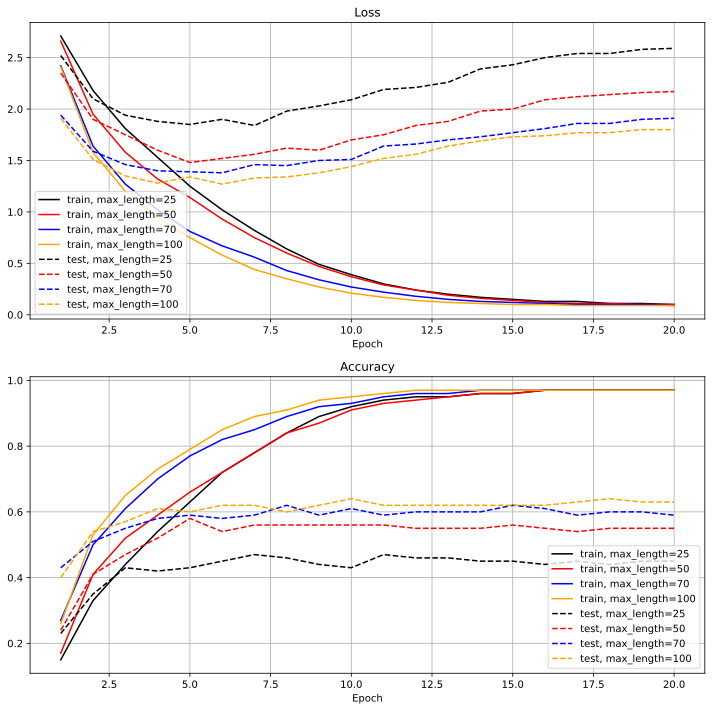

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

axes[0].plot(np.arange(20) + 1, loss_train[25], label='train, max_length=25', linestyle='-', c='black')
axes[0].plot(np.arange(20) + 1, loss_train[50], label='train, max_length=50', linestyle='-', c='r')
axes[0].plot(np.arange(20) + 1, loss_train[70], label='train, max_length=70', linestyle='-', c='b')
axes[0].plot(np.arange(20) + 1, loss_train[100], label='train, max_length=100', linestyle='-', c='orange')

axes[0].plot(np.arange(20) + 1, loss_test[25], label='test, max_length=25', linestyle='--', c='black')
axes[0].plot(np.arange(20) + 1, loss_test[50], label='test, max_length=50', linestyle='--', c='r')
axes[0].plot(np.arange(20) + 1, loss_test[70], label='test, max_length=70', linestyle='--', c='b')
axes[0].plot(np.arange(20) + 1, loss_test[100], label='test, max_length=100', linestyle='--', c='orange')

axes[1].plot(np.arange(20) + 1, acc_train[25], label='train, max_length=25', linestyle='-', c='black')
axes[1].plot(np.arange(20) + 1, acc_train[50], label='train, max_length=50', linestyle='-', c='r')
axes[1].plot(np.arange(20) + 1, acc_train[70], label='train, max_length=70', linestyle='-', c='b')
axes[1].plot(np.arange(20) + 1, acc_train[100], label='train, max_length=100', linestyle='-', c='orange')

axes[1].plot(np.arange(20) + 1, acc_test[25], label='test, max_length=25', linestyle='--', c='black')
axes[1].plot(np.arange(20) + 1, acc_test[50], label='test, max_length=50', linestyle='--', c='r')
axes[1].plot(np.arange(20) + 1, acc_test[70], label='test, max_length=70', linestyle='--', c='b')
axes[1].plot(np.arange(20) + 1, acc_test[100], label='test, max_length=100', linestyle='--', c='orange')

axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Epoch')
axes[0].set_title('Loss')

axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Epoch')
axes[1].set_title('Accuracy')

fig.tight_layout()
plt.show()

In [ ]:
input_ids, attention_masks, labels = tokenizing(X_train, y_train, max_length=100)
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dataloader = DataLoader(
        train_dataset,  # The training samples.
        sampler = RandomSampler(train_dataset), # Select batches randomly
        batch_size = 32 # Trains with this batch size.
    )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = 32 # Evaluate with this batch size.
        )
model = AlbertForSequenceClassification.from_pretrained(
        'albert-base-v2', # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 20, # The number of output labels--2 for binary classification.
                        # You can increase this for multi-class tasks.   
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
    )

# Tell pytorch to run this model on the GPU.
model.cuda()
optimizer = AdamW(model.parameters(),
                lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
            )
total_steps = len(train_dataloader) * 40

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
res1 = training(train_dataloader, validation_dataloader, optimizer, scheduler, epochs=40)

Downloading:   0%|          | 0.00/45.2M [00:00<?, ?B/s]

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.bias', 'predictions.bias', 'predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho


======== Epoch 1 / 40 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:25.
  Batch    80  of    155.    Elapsed: 0:00:50.
  Batch   120  of    155.    Elapsed: 0:01:14.

  Average training loss: 2.32
  Average training accuracy: 0.31
  Training epcoh took: 0:01:35

Running Validation...
  Accuracy: 0.53
  Validation Loss: 1.69
  Validation took: 0:00:04

======== Epoch 2 / 40 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:25.
  Batch    80  of    155.    Elapsed: 0:00:49.
  Batch   120  of    155.    Elapsed: 0:01:14.

  Average training loss: 1.49
  Average training accuracy: 0.56
  Training epcoh took: 0:01:35

Running Validation...
  Accuracy: 0.57
  Validation Loss: 1.37
  Validation took: 0:00:04

======== Epoch 3 / 40 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:25.
  Batch    80  of    155.    Elapsed: 0:00:49.
  Batch   120  of    155.    Elapsed: 0:01:13.

  Average training loss: 1.14
  Average training accuracy: 0.66
  Trai